In [8]:
# Goal: We have demonstrated that the 7774 line profile mangled fits the 63xx feature quite well, so
#       lets do that in a proper way!
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import numba
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.analysis.oxygen_lum as oxygen_lum
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils

egauss = np.vectorize(gaussian.elongated_gaussian)

In [2]:
# extract the base spectrum
sds = specds.load_dataset('SN2019odp')
spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']

# extract wave + flux without those pesky NaN that ruin everything
idx = ~np.isnan(spec['flux'])
wave = spec['restwave'][idx]
flux = spec['flux'][idx]

In [3]:
# generation function that generates the 63xx profile
C_KM_S = aconst.c.to(u.km/u.s).value
def generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum, wave_7774, flux_7774, wave_63xx):
    """
    Generate the 63xx feature.
    flux_7774 should already be continuum subtracted and total flux normalized to 1.0 (@6300)
    """
    
    # get projecting into the velocity space
    center_wave = 7774
    velocity = (wave_7774 - center_wave)/center_wave * C_KM_S
    
    # generate the matching wavelength grids for the velocities
    center_wave = 6300
    wave_6300 = velocity/C_KM_S * center_wave + center_wave
    center_wave = 6364
    wave_6364 = velocity/C_KM_S * center_wave + center_wave
    
    # re-project the 7774 flux onto the observed wavelength grid
    flux_6300 = np.interp(wave_63xx, wave_6300, flux_7774)*amp_6300
    flux_6364 = np.interp(wave_63xx, wave_6364, flux_7774)*amp_6300*ratio_6364
    
    # generate the continuum
    flux_cont = egauss(wave_63xx, 6300, outer_shell_amplitude, outer_shell_line_width, outer_shell_width) + egauss(wave_63xx, 6364, outer_shell_amplitude/3, outer_shell_line_width, outer_shell_width)
    
    flux = flux_6300 + flux_6364 + flux_cont + continuum
    return flux

def generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum, wave_7774, flux_7774, wave_5577):
    """
    Generate the 5577 feature.
    flux_7774 should already be continuum subtracted and total flux normalized to 1.0 (@6300)
    """
    
    # get projecting into the velocity space
    center_wave = 7774
    velocity = (wave_7774 - center_wave)/center_wave * C_KM_S
    
    # generate the matching wavelength grids for the velocities
    center_wave = 5577
    wave_5577_old = velocity/C_KM_S * center_wave + center_wave
    
    # re-project the 7774 flux onto the observed wavelength grid
    flux_5577 = np.interp(wave_5577, wave_5577_old, flux_7774)*amp_6300*ratio_5577
    
    # generate the outer shell continuum thingy
    flux_cont = egauss(wave_5577, 5577, outer_shell_amplitude * ratio_5577, outer_shell_line_width, outer_shell_width)
    
    #flux = flux_5577 + flux_cont + continuum
    flux = flux_5577 + continuum
    return flux

# function to pre-compute the 7774 flux
def premangle_7774_flux(spec, wave7774_min=7550, wave7774_max=8000, wave63xx_min=6050, wave63xx_max=6500):
    idx = np.logical_and(spec['restwave'] > wave7774_min, spec['restwave'] < wave7774_max)
    # remove those annyoing NaN
    idx = np.logical_and(idx, ~np.isnan(spec['flux']))
    wave = spec['restwave'][idx]
    flux = spec['flux'][idx]
    
    # create continuum subtracted flux
    flux_nocont = flux - np.nanpercentile(flux, 1)
    
    # reproject onto 6300 grid
    center_wave = 7774
    velocity = (wave - center_wave)/center_wave * C_KM_S

    #wave_grid = np.arange(6000, 6600, np.median(np.diff(wave))/2)
    idx = np.logical_and(spec['restwave'] > wave63xx_min, spec['restwave'] < wave63xx_max)
    # remove those annyoing NaN
    idx = np.logical_and(idx, ~np.isnan(spec['flux']))
    wave_grid = spec['restwave'][idx]
    
    center_wave = 6300
    wave_6300 = velocity/C_KM_S * center_wave + center_wave
    
    flux_6300 = np.interp(wave_grid, wave_6300, flux_nocont)
    
    # now calculate the flux of the reprojected line
    flux_int = np.trapz(flux_6300, wave_grid)
    #flux_oth = np.trapz(flux_nocont, wave_6300)
    #print(flux_int, flux_oth)
    
    # we want to normalize it 1.0
    norm_factor = 1.0/flux_int
    
    return wave, flux_nocont*norm_factor

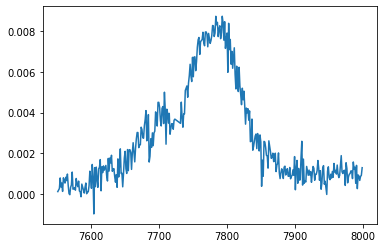

In [4]:
# test if the premangle function produces sensible results
wave, flux = premangle_7774_flux(spec)
plt.plot(wave, flux)

In [5]:
@numba.njit
def prior(u, min_continuum, max_continuum, max_line_amp):
    p = np.empty_like(u)
    
    # 6300 log amplitude
    p[0] = np.log(max_line_amp) - 20*u[0]
    
    # 6364/6300 ratio
    p[1] = 1/(1+2*u[1])
    
    # 5577/6300 ratio
    p[2] = np.exp(-5*u[2])
    
    # outer shell width
    p[3] = 150 + 150*u[3]
    
    # outer shell line width
    p[4] = 50*u[4]
    
    # log outer shell amplitude
    p[5] = np.log(max_line_amp/10) - 20*u[5]
    
    # continuum 63xx
    #p[6] = np.log(max_continuum) - 10*u[6]
    p[6] = (max_continuum-min_continuum)*u[6]+min_continuum
    
    # continuum 5577
    #p[7] = np.log(max_continuum) - 10*u[7]
    p[7] = (max_continuum-min_continuum)*u[7]+min_continuum
    
    return p

def likelihood(p, wave_7774, flux_7774, wave_63xx, flux_63xx, wave_5577, flux_5577, scale_factor):
    amp_6300 = np.exp(p[0])
    ratio_6364 = p[1]
    ratio_5577 = p[2]
    outer_shell_width = p[3]
    outer_shell_line_width = p[4]
    outer_shell_amplitude = np.exp(p[5])
    continuum_63xx = p[6]
    continuum_5577 = p[7]
    
    model_flux_63xx = generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774, flux_7774, wave_63xx)
    #sigma2_63xx = 1/scale_factor**2 + model_flux_63xx ** 2 * np.exp(2*log_f)
    
    model_flux_5577 = generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774, flux_7774, wave_5577)
    
    logl_63xx = -0.5*np.sum( (model_flux_63xx*scale_factor - flux_63xx*scale_factor)**2 )
    
    logl_5577 = -0.5*np.sum( (model_flux_5577*scale_factor - flux_5577*scale_factor)**2 )
    
    return logl_63xx+logl_5577

def render_func(p, wave_7774, flux_7774, wave_63xx, wave_5577):
    amp_6300 = np.exp(p[0])
    ratio_6364 = p[1]
    ratio_5577 = p[2]
    outer_shell_width = p[3]
    outer_shell_line_width = p[4]
    outer_shell_amplitude = np.exp(p[5])
    continuum_63xx = p[6]
    continuum_5577 = p[7]
    
    model_flux_63xx = generation_func_63xx(amp_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774, flux_7774, wave_63xx)
    
    model_flux_5577 = generation_func_5577(amp_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774, flux_7774, wave_5577)
    
    return model_flux_63xx, model_flux_5577

def extract_region(spec, wave_min, wave_max):
    idx = np.logical_and(spec['restwave'] > wave_min, spec['restwave'] < wave_max)
    # remove those annyoing NaN
    idx = np.logical_and(idx, ~np.isnan(spec['flux']))
    wave = spec['restwave'][idx]
    flux = spec['flux'][idx]
    
    return wave, flux

def run_fit(spec, regions={}, dynesty_method='unif', dynesty_pfrac=0.5, nlive_init=3000):
    wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
    
    # extract the 63xx region
    wave_63xx, flux_63xx = extract_region(spec, regions['63xx_min'], regions['63xx_max'])
    
    # extract the 5577 region
    wave_5577, flux_5577 = extract_region(spec, regions['5577_min'], regions['5577_max'])
    
    # for now fixed configured scale factor
    scale_factor = np.sqrt(2)/7.002413899090286e-18
    
    prior_args = (np.nanpercentile(spec['flux'], 1), 2*np.nanpercentile(spec['flux'], 40), np.nanpercentile(spec['flux'], 95)*1e6)
    
    logl_args = (wave_7774, flux_7774, wave_63xx, flux_63xx, wave_5577, flux_5577, scale_factor)
    
    ndim = 8
    
    sampler = dynesty.DynamicNestedSampler(likelihood, prior, ndim,
                                           logl_args=logl_args,
                                           nlive=8000,
                                           ptform_args=prior_args,
                                           method=dynesty_method,
                                           slices=7,
                                           enlarge=3,
                                           walks=50)
    sampler.run_nested(nlive_init=nlive_init, wt_kwargs={'pfrac': dynesty_pfrac})
    results = sampler.results
    
    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    #if not quiet:
    print('\tMean: %s' % repr(mean))
    print('\n\t\t'.join(('\tCov: %s' % repr(cov)).split('\n')))

    new_samples = dyfunc.resample_equal(samples, weights)
    
    return sampler, new_samples

In [6]:
regions = {
    '7774_min': 7550,
    '7774_max': 8000,
    '63xx_min': 6100,
    '63xx_max': 6540,
    '5577_min': 5400,
    '5577_max': 5650
}

sampler, trace = run_fit(spec, regions)

143079it [1:01:05, 39.04it/s, batch: 0 | bound: 389 | nc: 1 | ncall: 1865338 | eff(%):  7.670 | loglstar:   -inf < -2087.082 <    inf | logz: -2129.162 +/-  0.158 | dlogz:  0.000 >  0.010]  


	Mean: array([-3.12918323e+01,  3.33572133e-01,  2.16360238e-01,  1.50287728e+02,
        4.74568570e+01, -3.16676814e+01,  5.58584121e-17,  8.79308446e-17])
	Cov: array([[ 5.88880299e-05, -1.09259263e-08, -1.29083036e-05,
		         1.59863471e-04,  4.86429816e-03, -8.06664909e-06,
		        -3.99027762e-21, -5.24244853e-24],
		       [-1.09259263e-08,  5.48905396e-08,  1.07460337e-08,
		        -8.83618888e-08, -3.36014092e-07, -6.27511768e-08,
		         1.67484771e-24, -1.92178706e-24],
		       [-1.29083036e-05,  1.07460337e-08,  3.68006963e-05,
		        -5.08894840e-05, -1.06152218e-03,  2.04653170e-06,
		         8.70824080e-22, -2.96849303e-21],
		       [ 1.59863471e-04, -8.83618888e-08, -5.08894840e-05,
		         8.10360763e-02, -1.46972366e-02, -9.35989977e-05,
		        -7.41460241e-21,  1.57343708e-21],
		       [ 4.86429816e-03, -3.36014092e-07, -1.06152218e-03,
		        -1.46972366e-02,  1.16917961e+00,  1.23467002e-02,
		        -1.00508073e-18, -4.52228442e-21],
		 

In [7]:
weights = np.exp(sampler.results.logwt - sampler.results.logz[-1])
mean, cov = dyfunc.mean_and_cov(trace, weights)
print('Mean', mean)
print('Cov', cov)

mean, cov = dyfunc.mean_and_cov(trace[:,(0,1,2)], weights)
print('Mean', mean)
print('cov', cov)

Mean [-3.12919291e+01  3.33469089e-01  2.16492492e-01  1.50163403e+02
  4.74971374e+01 -3.16672390e+01  5.58512989e-17  8.79288632e-17]
Cov [[ 3.39096297e-05 -1.35614288e-08 -6.87269419e-06  4.42517866e-05
   2.95820954e-03 -2.50503995e-06 -2.40836094e-21 -4.54402951e-23]
 [-1.35614288e-08  1.19086414e-08  3.12960411e-09 -3.52571094e-06
  -1.77265246e-06 -5.02999611e-08  3.05642553e-24 -1.22988102e-25]
 [-6.87269419e-06  3.12960411e-09  2.04786441e-05 -7.13135263e-06
  -6.53244209e-04 -2.57739237e-07  5.23191563e-22 -1.65087300e-21]
 [ 4.42517866e-05 -3.52571094e-06 -7.13135263e-06  1.75481879e-02
  -1.82829038e-03 -5.14133320e-06 -2.00264136e-21 -1.38369430e-21]
 [ 2.95820954e-03 -1.77265246e-06 -6.53244209e-04 -1.82829038e-03
   7.00180901e-01  7.22960173e-03 -5.96812704e-19  1.38671467e-21]
 [-2.50503995e-06 -5.02999611e-08 -2.57739237e-07 -5.14133320e-06
   7.22960173e-03  1.60942026e-04 -8.22400197e-21  8.79502883e-23]
 [-2.40836094e-21  3.05642553e-24  5.23191563e-22 -2.00264136e

In [10]:
# try the oxygen-luminosity secondary stage
dist_range = ((64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm))
lum_cfg = oxygen_lum.make_setup(dist_range=dist_range, mode='mv_normal', line_profile_fit_result=sampler.results)
lum_results, lum_trace, lum_sampler =  oxygen_lum.run_dynesty_fit(lum_cfg)

66617it [12:02, 92.25it/s, batch: 3 | bound: 89 | nc: 18 | ncall: 384247 | eff(%): 17.337 | loglstar: 12.162 < 15.604 < 14.797 | logz:  0.457 +/-  0.095 | stop:  0.942]                   


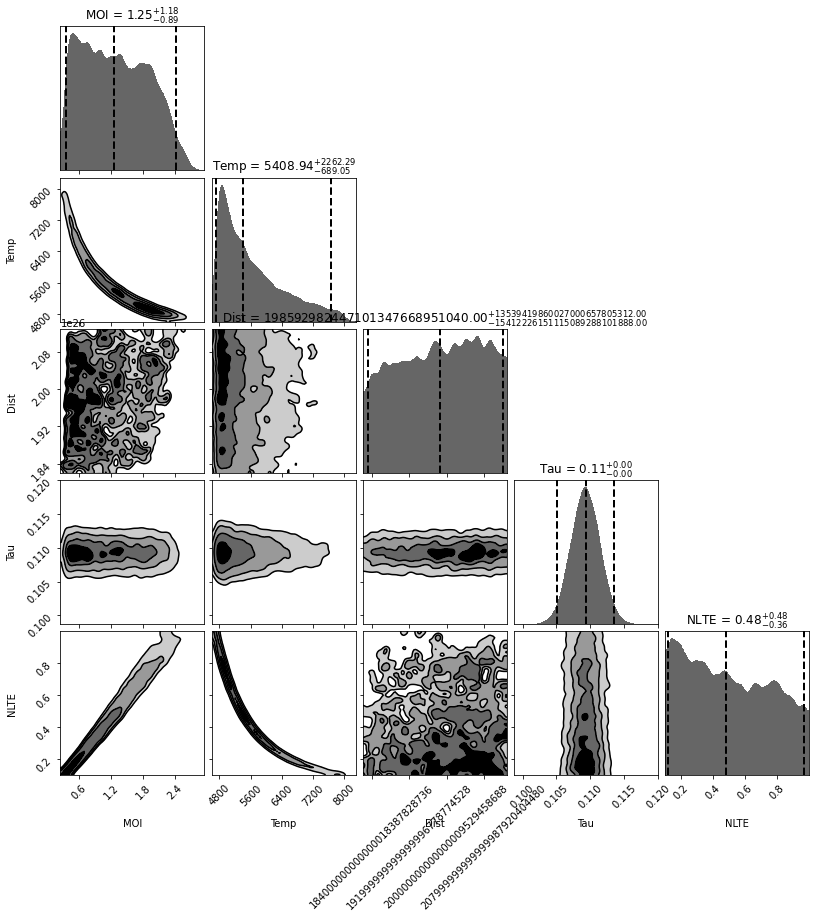

In [11]:
LABELS = ['MOI', 'Temp', 'Dist', 'Tau', 'NLTE']
dyplot.cornerplot(lum_results, labels=LABELS, show_titles=True);

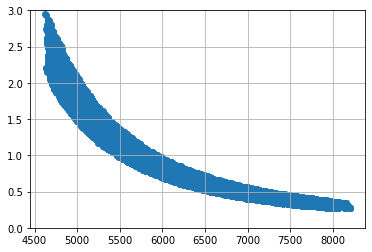

In [13]:
plt.scatter(lum_trace[:,1], lum_trace[:,0])
plt.ylim((0,3))
plt.grid();

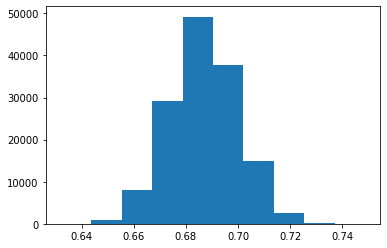

In [19]:
# Ratio between the main 6300 peak and the shell amplitude
plt.hist(np.exp(trace[:,5] - trace[:,0]))
ratio_mean = np.mean(np.exp(trace[:,5] - trace[:,0]))
ratio_std = np.std(np.exp(trace[:,5] - trace[:,0]))

In [20]:
plt.scatter(lum_trace[:,1], lum_trace[:,0] * (1+np.random.normal(ratio_mean, ratio_std, size=len(lum_trace))))
plt.ylim((0,3))
plt.grid();

In [17]:
plt.scatter(lum_trace[:,1], lum_trace[:,0] * (1+0.69))
plt.ylim((0,3))
plt.grid();

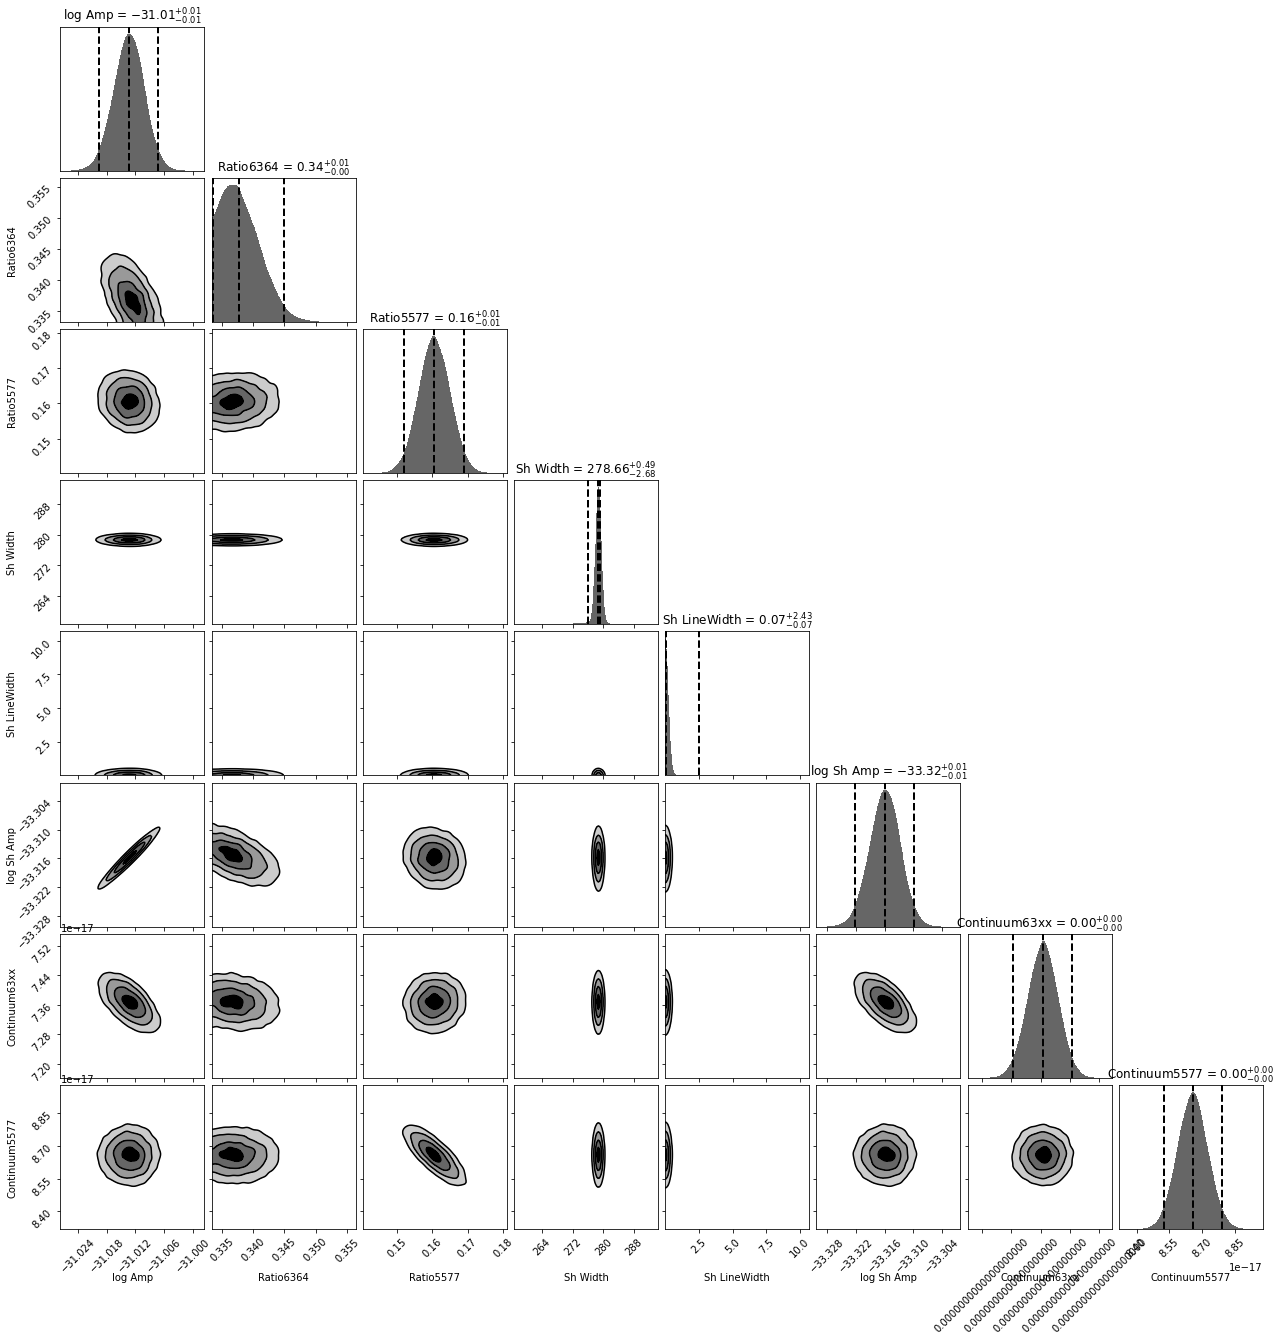

In [109]:
LABELS = ['log Amp', 'Ratio6364', 'Ratio5577', 'Sh Width', 'Sh LineWidth', 'log Sh Amp', 'Continuum63xx', 'Continuum5577']
dyplot.cornerplot(sampler.results, labels=LABELS, show_titles=True);
plt.savefig('2022-08-18-7774-mangle-unconstrained-corner.png')

In [50]:
def show(spec, regions, trace, ax_5577, ax_63xx, num_samples=1000):
    wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
    
    # extract the 63xx region
    wave_63xx, flux_63xx = extract_region(spec, regions['63xx_min'], regions['63xx_max'])
    
    # extract the 5577 region
    wave_5577, flux_5577 = extract_region(spec, regions['5577_min'], regions['5577_max'])
    
    ax_5577.plot(wave_5577, flux_5577, label='Spec', color='red')
    ax_63xx.plot(wave_63xx, flux_63xx, label='Spec', color='red')
    
    for idx in np.random.randint(trace.shape[0], size=num_samples):
        p = trace[idx]
        flux_63xx, flux_5577 = render_func(p, wave_7774, flux_7774, wave_63xx, wave_5577)
        ax_5577.plot(wave_5577, flux_5577, color='grey', alpha=0.05, lw=1)
        ax_63xx.plot(wave_63xx, flux_63xx, color='grey', alpha=0.05, lw=1)
        
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show(spec, regions, trace, ax1, ax2)


In [51]:
# calculate the line luminosities
dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)

print('6300', np.nanpercentile(lums_6300/1e38, [15, 50, 85]))
print('6364', np.nanpercentile(lums_6364/1e38, [15, 50, 85]))
print('5577', np.nanpercentile(lums_5577/1e38, [15, 50, 85]))

6300 [165.92974775 166.48453141 167.01571297]
6364 [55.80912231 56.23393195 56.77367854]
5577 [25.98128257 26.7262753  27.49544886]


(array([   35.,   162.,   774.,  2441.,  6820., 13513., 21563., 28040.,
        28719., 24236.]),
 array([2.83466199, 2.85119563, 2.86772927, 2.88426291, 2.90079655,
        2.91733019, 2.93386383, 2.95039748, 2.96693112, 2.98346476,
        2.9999984 ]),
 <BarContainer object of 10 artists>)

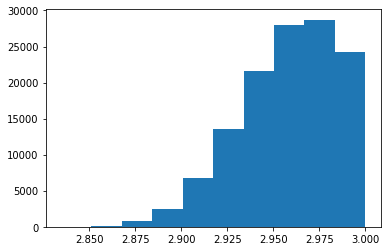

In [52]:
plt.hist(1/trace[:,1])

(array([2.2000e+01, 8.1900e+02, 8.7530e+03, 3.0968e+04, 4.4563e+04,
        2.9693e+04, 9.4880e+03, 1.8180e+03, 1.6600e+02, 1.3000e+01]),
 array([5.51898128, 5.67638058, 5.83377989, 5.99117919, 6.14857849,
        6.30597779, 6.46337709, 6.6207764 , 6.7781757 , 6.935575  ,
        7.0929743 ]),
 <BarContainer object of 10 artists>)

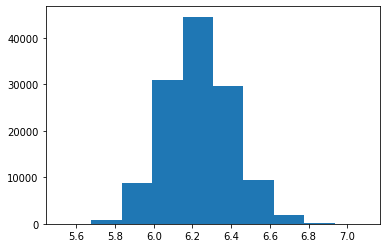

In [56]:
plt.hist(1/trace[:,2])

(array([2.2000e+01, 3.3700e+02, 3.5400e+03, 1.7011e+04, 3.9118e+04,
        4.1034e+04, 2.0552e+04, 4.3210e+03, 3.5900e+02, 9.0000e+00]),
 array([4377.74651596, 4397.22210307, 4416.69769018, 4436.1732773 ,
        4455.64886441, 4475.12445152, 4494.60003864, 4514.07562575,
        4533.55121286, 4553.02679998, 4572.50238709]),
 <BarContainer object of 10 artists>)

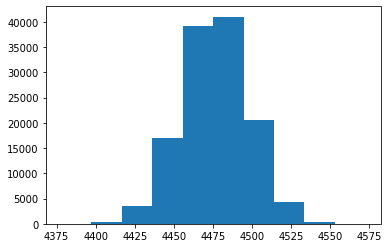

In [54]:
# estimate temperature
beta_ratio = 1.0
temp = -1/(np.log(lums_5577/lums_6300/51/beta_ratio)/25789)
plt.hist(temp)

In [46]:
np.nanpercentile(spec['flux'], 1)

4.043282085941341e-18

(array([2.3000e+01, 9.8200e+02, 1.0352e+04, 3.3315e+04, 4.5260e+04,
        2.7211e+04, 7.8060e+03, 1.2380e+03, 1.0800e+02, 8.0000e+00]),
 array([3.30376484, 3.38823364, 3.47270243, 3.55717122, 3.64164002,
        3.72610881, 3.81057761, 3.8950464 , 3.9795152 , 4.06398399,
        4.14845279]),
 <BarContainer object of 10 artists>)

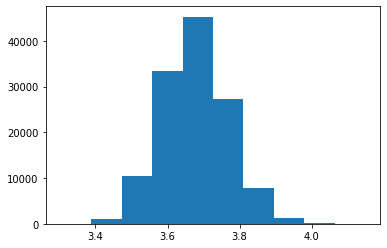

In [55]:
lums_63xx = lums_6300 + lums_6364
mass = lums_63xx/9.7e41 * np.exp(22720/temp)
plt.hist(mass)

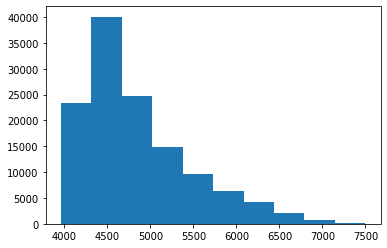

In [60]:
d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
beta_ratio = np.random.uniform(1.0, 2.0, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)

temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)

plt.hist(temp);

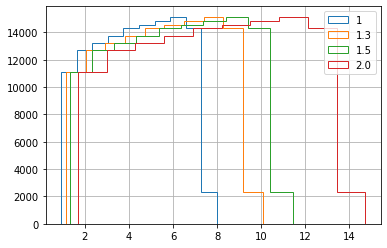

In [113]:
d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
#beta_ratio = np.random.uniform(1.0, 2.0, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)

for beta_ratio in [1, 1.3, 1.5, 2.0]:
    temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)

    lums_63xx = lums_6300 + lums_6364
    mass = lums_63xx/9.7e41 * np.exp(22720/temp)/0.5
    plt.hist(mass, histtype='step', label=f'{beta_ratio}');
plt.grid()
plt.legend()

#plt.hist(temp);

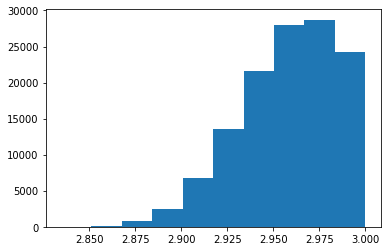

In [116]:
plt.hist(1/trace[:,1]);

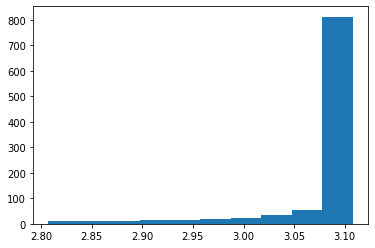

In [125]:
tau = np.logspace(-6, -0.5, 1000)
beta_6300 = oxygen.tau_to_beta(tau)
beta_6364 = oxygen.tau_to_beta(tau/3)
plt.hist(beta_6300/beta_6364*oxygen.LUM_6300_PRE_FACTOR/oxygen.LUM_6364_PRE_FACTOR);
# this suggests that tau goes up to 0.6

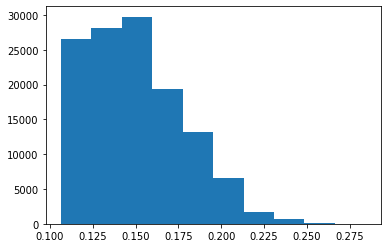

In [151]:
# compute tau from the observed line ratio

# first compute the LUT
tau = np.logspace(-6, 0, 1000)[::-1]
beta_6300 = oxygen.tau_to_beta(tau)
beta_6364 = oxygen.tau_to_beta(tau/3)
beta_ratio = beta_6300/beta_6364*oxygen.LUM_6300_PRE_FACTOR/oxygen.LUM_6364_PRE_FACTOR
#print(beta_ratio)

idxs = np.searchsorted(beta_ratio, 1/trace[:,1])
tau_6300 = tau[idxs]
plt.hist(tau_6300);

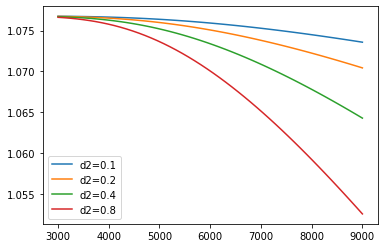

In [155]:
temp = np.linspace(3000, 9000)
for d2 in [0.1, 0.2, 0.4, 0.8]:
    tau_5577 = tau_6300.mean()*oxygen.calculate_5577_optical_depth(tau_6300.mean(), temp, d2)
    beta_5577 = oxygen.tau_to_beta(tau_5577)
    beta_6300 = oxygen.tau_to_beta(tau_6300.mean())
    plt.plot(temp, beta_5577/beta_6300, label=f'd2={d2}')
plt.legend()

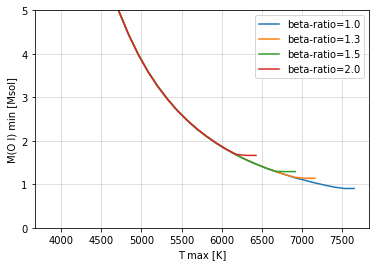

In [141]:
d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
#beta_ratio = np.random.uniform(1.0, 2.0, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)

for beta_ratio in [1.0, 1.3, 1.5, 2.0]:
    temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)

    lums_63xx = lums_6300 + lums_6364
    mass = lums_63xx/9.7e41 * np.exp(22720/temp)/0.5

    tmax = np.linspace(3000, 9000)
    d_tmax = np.diff(tmax).mean()
    mass_min = np.empty_like(tmax)
    for i in range(len(tmax)):
        #idx = temp < tmax[i]
        idx = np.abs(temp - tmax[i]) < d_tmax
        if np.count_nonzero(idx) == 0:
            mass_min[i] = np.nan
        else:
            mass_min[i] = mass[idx].min()
    plt.plot(tmax, mass_min, label=f'beta-ratio={beta_ratio}');
plt.grid(alpha=0.5)
plt.legend()
plt.xlabel('T max [K]')
plt.ylim((0,5))
plt.ylabel('M(O I) min [Msol]');

0.5240822589126748


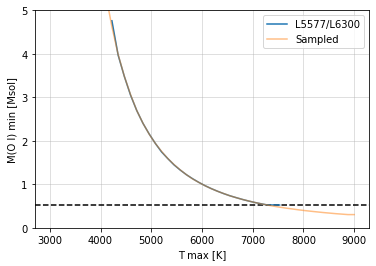

In [173]:
d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
beta_ratio = np.random.uniform(1.0, 1.5, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)

temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)
tau_5577 = tau_6300*oxygen.calculate_5577_optical_depth(tau_6300, temp, d2)
beta_6300 = oxygen.tau_to_beta(tau_6300)
beta_5577 = oxygen.tau_to_beta(tau_5577)
beta_ratio = beta_5577/beta_6300

#for beta_ratio in [1.0, 1.3, 1.5, 2.0]:
temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)

lums_63xx = lums_6300 + lums_6364
#mass = lums_63xx/9.7e41 * np.exp(22720/temp)/0.5
mass = lums_6300/oxygen.LUM_6300_PRE_FACTOR*np.exp(oxygen.LUM_63XX_TEMP_FACTOR/temp)/beta_6300

tmax = np.linspace(3000, 9000)
d_tmax = np.diff(tmax).mean()
mass_min = np.empty_like(tmax)
for i in range(len(tmax)):
    #idx = temp < tmax[i]
    idx = np.abs(temp - tmax[i]) < d_tmax
    if np.count_nonzero(idx) == 0:
        mass_min[i] = np.nan
    else:
        mass_min[i] = mass[idx].min()
plt.axhline(np.nanmin(mass_min), ls='--', color='black')
print(np.nanmin(mass_min))
plt.plot(tmax, mass_min, label=f'L5577/L6300');
plt.grid(alpha=0.5)

temp = np.random.uniform(3000, 9000, size=trace.shape[0])
mass = lums_6300/oxygen.LUM_6300_PRE_FACTOR*np.exp(oxygen.LUM_63XX_TEMP_FACTOR/temp)/beta_6300

tmax = np.linspace(3000, 9000)
d_tmax = np.diff(tmax).mean()
mass_min = np.empty_like(tmax)
for i in range(len(tmax)):
    #idx = temp < tmax[i]
    idx = np.abs(temp - tmax[i]) < d_tmax
    if np.count_nonzero(idx) == 0:
        mass_min[i] = np.nan
    else:
        mass_min[i] = mass[idx].min()
plt.plot(tmax, mass_min, label=f'Sampled', alpha=0.5);
plt.legend()
plt.xlabel('T max [K]')
plt.ylim((0,5))
plt.ylabel('M(O I) min [Msol]');

0.059010244971352606


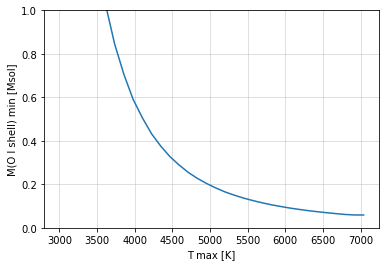

In [170]:
d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
beta_ratio = np.random.uniform(1.0, 1.5, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)
lums_6300_shell = utils.flux2luminosity(np.exp(trace[:,5]), dist_cm)
lums_5577_shell = utils.flux2luminosity(trace[:,5]*trace[:,2], dist_cm)

temp = np.random.uniform(3000, 7000, size=trace.shape[0])
mass = lums_6300_shell/oxygen.LUM_6300_PRE_FACTOR*np.exp(oxygen.LUM_63XX_TEMP_FACTOR/temp)

tmax = np.linspace(3000, 9000)
d_tmax = np.diff(tmax).mean()
mass_min = np.empty_like(tmax)
for i in range(len(tmax)):
    #idx = temp < tmax[i]
    idx = np.abs(temp - tmax[i]) < d_tmax
    if np.count_nonzero(idx) == 0:
        mass_min[i] = np.nan
    else:
        mass_min[i] = mass[idx].min()
print(np.nanmin(mass_min))
plt.plot(tmax, mass_min);
plt.grid(alpha=0.5)
#plt.legend()
plt.xlabel('T max [K]')
plt.ylim((0,1))
plt.ylabel('M(O I shell) min [Msol]');

-1.1


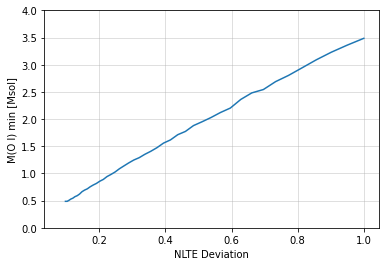

In [178]:
d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
beta_ratio = np.random.uniform(1.0, 1.5, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)
lums_6300_shell = utils.flux2luminosity(np.exp(trace[:,5]), dist_cm)
lums_5577_shell = utils.flux2luminosity(trace[:,5]*trace[:,2], dist_cm)

temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)
tau_5577 = tau_6300*oxygen.calculate_5577_optical_depth(tau_6300, temp, d2)
beta_6300 = oxygen.tau_to_beta(tau_6300)
beta_5577 = oxygen.tau_to_beta(tau_5577)
beta_ratio = beta_5577/beta_6300

#for beta_ratio in [1.0, 1.3, 1.5, 2.0]:
temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)

#temp = np.random.uniform(3000, 7000, size=trace.shape[0])
mass = lums_6300/oxygen.LUM_6300_PRE_FACTOR*np.exp(oxygen.LUM_63XX_TEMP_FACTOR/temp)

d2_t = np.logspace(-1.1, 0)
d_d2 = np.diff(d2_t)
mass_min = np.empty_like(d2_t)
for i in range(1, len(d2_t)):
    #idx = temp < tmax[i]
    idx = np.abs(d2 - d2_t[i]) < d_d2[i-1]
    if np.count_nonzero(idx) == 0:
        mass_min[i] = np.nan
    else:
        mass_min[i] = mass[idx].min()
print(np.nanmin(mass_min))
plt.plot(d2_t, mass_min);
plt.grid(alpha=0.5)
#plt.legend()
plt.xlabel('NLTE Deviation')
plt.ylim((0,4))
plt.ylabel('M(O I) min [Msol]');

0.4673421027370398
0.86394434972983
1.597116619835292
2.952483569285201


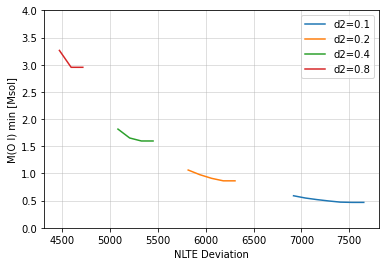

In [179]:
#d2 = np.random.uniform(0.1, 1.0, size=trace.shape[0])
beta_ratio = np.random.uniform(1.0, 1.5, size=trace.shape[0])

dist_cm = 64e6*u.pc.to(u.cm)
flux_6300 = np.exp(trace[:,0])
flux_6364 = flux_6300 * trace[:,1]
flux_5577 = flux_6300 * trace[:,2]

lums_6300 = utils.flux2luminosity(flux_6300, dist_cm)
lums_6364 = utils.flux2luminosity(flux_6364, dist_cm)
lums_5577 = utils.flux2luminosity(flux_5577, dist_cm)
lums_6300_shell = utils.flux2luminosity(np.exp(trace[:,5]), dist_cm)
lums_5577_shell = utils.flux2luminosity(trace[:,5]*trace[:,2], dist_cm)

temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)
tau_5577 = tau_6300*oxygen.calculate_5577_optical_depth(tau_6300, temp, d2)
beta_6300 = oxygen.tau_to_beta(tau_6300)
beta_5577 = oxygen.tau_to_beta(tau_5577)
beta_ratio = beta_5577/beta_6300

#for beta_ratio in [1.0, 1.3, 1.5, 2.0]:
for d2 in [0.1, 0.2, 0.4, 0.8]:
    temp = 1 / (np.log(lums_5577/lums_6300/d2/51/beta_ratio)/-25789)

    #temp = np.random.uniform(3000, 7000, size=trace.shape[0])
    mass = lums_6300/oxygen.LUM_6300_PRE_FACTOR*np.exp(oxygen.LUM_63XX_TEMP_FACTOR/temp)

    tmax = np.linspace(3000, 9000)
    d_tmax = np.diff(tmax).mean()
    mass_min = np.empty_like(tmax)
    for i in range(len(tmax)):
        #idx = temp < tmax[i]
        idx = np.abs(temp - tmax[i]) < d_tmax
        if np.count_nonzero(idx) == 0:
            mass_min[i] = np.nan
        else:
            mass_min[i] = mass[idx].min()
    print(np.nanmin(mass_min))
    plt.plot(tmax, mass_min, label=f'd2={d2}');
plt.grid(alpha=0.5)
plt.legend()
plt.xlabel('NLTE Deviation')
plt.ylim((0,4))
plt.ylabel('M(O I) min [Msol]');

In [ ]:
#### TODO: calculate beta_ratio based on optical_depth and d2

# .1: Convert the ratio into the optical depth

# .2: Calculate beta_ratio from optical_depth + temp + d2 // uh.. but need temp for that hmmmm

In [105]:
@numba.njit
def prior2(u, min_continuum, max_continuum, max_line_amp, distance_min, distance_max, nlte_departure_max):
    p = np.empty_like(u)
    
    # oxygen mass [Msol]
    p[0] = 6*u[0]

    # temperature [K]
    p[1] = np.exp(2.4*u[1]+6.9)

    # unused: line width [A]
    #x[2] = max_width/2 * (1+u[2])
    # outer shell width
    p[2] = 150 + 150*u[2]

    # unused: continuum level 5577
    #x[3] = 2*max_continuum*u[3]-max_continuum
    # outer shell line width
    p[3] = 50*u[3]

    # unused: continuum level 6300,6364
    #x[4] = 2*max_continuum*u[4]-max_continuum
    # log outer shell amplitude
    p[4] = np.log(max_line_amp/10) - 20*u[4]

    # unused: continuum slope 5577
    #x[5] = 0.02*u[5]-0.01
    # continuum 63xx
    p[5] = (max_continuum-min_continuum)*u[5]+min_continuum
    
    # unused: continuum slope 6300,6364
    #x[6] = 0.01*u[6]-0.005
    # continuum 5577
    #p[7] = np.log(max_continuum) - 10*u[7]
    p[6] = (max_continuum-min_continuum)*u[6]+min_continuum

    # distance
    p[7] = (distance_max-distance_min)*u[7] + distance_min
    
    # wavelength offset [A]
    p[8] = 8*u[8]-5

    # nuisance parameter: optical depth
    p[9] = np.exp(5*u[9] - 3)

    # nuisance parameter: log f
    p[10] = 12*u[10] - 10

    # nuisance parameter: NLTE departure coefficient
    # in NLTE mode the ratio can fall below one
    # range is 0.05 - 1.0
    p[11] = np.exp(np.log(nlte_departure_max)*u[11])
    
    return p

def likelihood2(p, wave_7774, flux_7774, wave_63xx, flux_63xx, wave_5577, flux_5577, scale_factor):
    # extract the new things we need
    outer_shell_width = p[2]
    outer_shell_line_width = p[3]
    outer_shell_amplitude = np.exp(p[4])
    continuum_63xx = p[5]
    continuum_5577 = p[6]
    
    # extract the other old things we need
    wlen_offset = p[8]
    log_f = p[10]
    
    # use the old algorithm to create the fluxes
    # uses 0, 1, 7, 9, 11
    fluxes = oxygen.create_fluxes(p)
    flux_5577 = fluxes[0]
    flux_6300 = fluxes[1]
    flux_6364 = fluxes[2]
    # convert to the different format used by the new generation functions
    ratio_6364 = flux_6364/flux_6300
    ratio_5577 = flux_5577/flux_6300
    
    model_flux_63xx = generation_func_63xx(flux_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774+wlen_offset, flux_7774, wave_63xx+wlen_offset)
    sigma2_63xx = 1/scale_factor**2 + model_flux_63xx**2 * np.exp(2*log_f)
    
    model_flux_5577 = generation_func_5577(flux_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774+wlen_offset, flux_7774, wave_5577+wlen_offset)
    sigma2_5577 = 1/scale_factor**2 + model_flux_5577**2 * np.exp(2*log_f)
    
    logl_63xx = -0.5*np.sum( (model_flux_63xx - flux_63xx)**2 / sigma2_63xx + np.log(sigma2_63xx) )
    
    logl_5577 = -0.5*np.sum( (model_flux_5577 - flux_5577)**2 / sigma2_5577 + np.log(sigma2_5577) )
    
    #logl_63xx = -0.5*np.sum( (model_flux_63xx*scale_factor - flux_63xx*scale_factor)**2)
    
    #logl_5577 = -0.5*np.sum( (model_flux_5577*scale_factor - flux_5577*scale_factor)**2)
    
    
    return logl_63xx+logl_5577

def render_func2(p, wave_7774, flux_7774, wave_63xx, wave_5577):
    # extract the new things we need
    outer_shell_width = p[2]
    outer_shell_line_width = p[3]
    outer_shell_amplitude = np.exp(p[4])
    continuum_63xx = p[5]
    continuum_5577 = p[6]
    
    # extract the other old things we need
    wlen_offset = p[8]
    log_f = p[10]
    
    # use the old algorithm to create the fluxes
    # uses 0, 1, 7, 9, 11
    fluxes = oxygen.create_fluxes(p)
    flux_5577 = fluxes[0]
    flux_6300 = fluxes[1]
    flux_6364 = fluxes[2]
    # convert to the different format used by the new generation functions
    ratio_6364 = flux_6364/flux_6300
    ratio_5577 = flux_5577/flux_6300
    
    model_flux_63xx = generation_func_63xx(flux_6300, ratio_6364, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_63xx, wave_7774+wlen_offset, flux_7774, wave_63xx+wlen_offset)
    
    model_flux_5577 = generation_func_5577(flux_6300, ratio_5577, outer_shell_width, outer_shell_line_width, outer_shell_amplitude, continuum_5577, wave_7774+wlen_offset, flux_7774, wave_5577+wlen_offset)
    
    return model_flux_63xx, model_flux_5577

def run_fit2(spec, regions={}, dynesty_method='unif', dynesty_pfrac=0.5, nlive_init=3000):
    wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
    
    # extract the 63xx region
    wave_63xx, flux_63xx = extract_region(spec, regions['63xx_min'], regions['63xx_max'])
    
    # extract the 5577 region
    wave_5577, flux_5577 = extract_region(spec, regions['5577_min'], regions['5577_max'])
    
    # for now fixed configured scale factor
    scale_factor = np.sqrt(2)/7.002413899090286e-18
    
    dist_min, dist_max = oxygen.redshift2distance(const.redshift-const.redshift_err, const.redshift+const.redshift_err)
    nlte_departure_max = 0.01
    
    prior_args = (np.nanpercentile(spec['flux'], 1), 2*np.nanpercentile(spec['flux'], 40), np.nanpercentile(spec['flux'], 95)*1e6, dist_min, dist_max, nlte_departure_max)
    
    logl_args = (wave_7774, flux_7774, wave_63xx, flux_63xx, wave_5577, flux_5577, scale_factor)
    
    ndim = 12
    
    sampler = dynesty.DynamicNestedSampler(likelihood2, prior2, ndim,
                                           logl_args=logl_args,
                                           nlive=8000,
                                           ptform_args=prior_args,
                                           method=dynesty_method,
                                           slices=7,
                                           enlarge=3,
                                           walks=50)
    sampler.run_nested(nlive_init=nlive_init, wt_kwargs={'pfrac': dynesty_pfrac})
    results = sampler.results
    
    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    #if not quiet:
    print('\tMean: %s' % repr(mean))
    print('\n\t\t'.join(('\tCov: %s' % repr(cov)).split('\n')))

    new_samples = dyfunc.resample_equal(samples, weights)
    
    return sampler, new_samples

def show2(spec, regions, trace, ax_5577, ax_63xx, num_samples=1000):
    wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
    
    # extract the 63xx region
    wave_63xx, flux_63xx = extract_region(spec, regions['63xx_min'], regions['63xx_max'])
    
    # extract the 5577 region
    wave_5577, flux_5577 = extract_region(spec, regions['5577_min'], regions['5577_max'])
    
    ax_5577.plot(wave_5577, flux_5577, label='Spec', color='red')
    ax_63xx.plot(wave_63xx, flux_63xx, label='Spec', color='red')
    
    for idx in np.random.randint(trace.shape[0], size=num_samples):
        p = trace[idx]
        mod_flux_63xx, mod_flux_5577 = render_func2(p, wave_7774, flux_7774, wave_63xx, wave_5577)
        ax_5577.plot(wave_5577, mod_flux_5577, color='grey', alpha=0.05, lw=1)
        ax_63xx.plot(wave_63xx, mod_flux_63xx, color='grey', alpha=0.05, lw=1)

In [106]:
regions2 = {
    '7774_min': 7550,
    '7774_max': 8000,
    '63xx_min': 6100,
    '63xx_max': 6540,
    '5577_min': 5400,
    '5577_max': 5650
}

sampler7, trace7 = run_fit2(spec, regions2)

145386it [2:05:36, 19.29it/s, batch: 0 | bound: 365 | nc: 1 | ncall: 6910795 | eff(%):  2.104 | loglstar:   -inf < 20495.357 <    inf | logz: 20452.506 +/-  0.156 | dlogz:  0.000 >  0.010]   


	Mean: array([ 5.64562709e+00,  3.94726199e+03,  1.53584298e+02,  4.79543988e+01,
       -3.16026125e+01,  5.51331313e-17,  2.02136599e-17,  1.98155459e+26,
       -3.59176030e-01,  6.96736343e-02, -2.57660337e+00,  1.08417028e-02])
	Cov: array([[ 8.21904814e-02, -1.00726127e+01,  1.69760108e-02,
		         1.11845398e-02, -3.44693898e-04, -1.15278883e-20,
		        -2.99819498e-19, -4.13871227e+19,  5.66873830e-04,
		         1.26283989e-05,  5.32418628e-04,  1.76208719e-05],
		       [-1.00726127e+01,  1.58659099e+03,  1.66991057e+01,
		         5.79193955e+00, -2.71140624e-01, -1.05826997e-17,
		         5.67887948e-17,  5.43931733e+22,  3.54662581e-01,
		         9.64060958e-02, -1.60668260e-01, -3.28418718e-03],
		       [ 1.69760108e-02,  1.66991057e+01,  1.01012798e+01,
		        -1.03726184e+00, -1.00627579e-02, -1.53202397e-18,
		         9.98456430e-19, -2.24913324e+21, -5.41412465e-03,
		         1.09804888e-04,  9.88475929e-03, -6.93626352e-05],
		       [ 1.11845398e-02,  

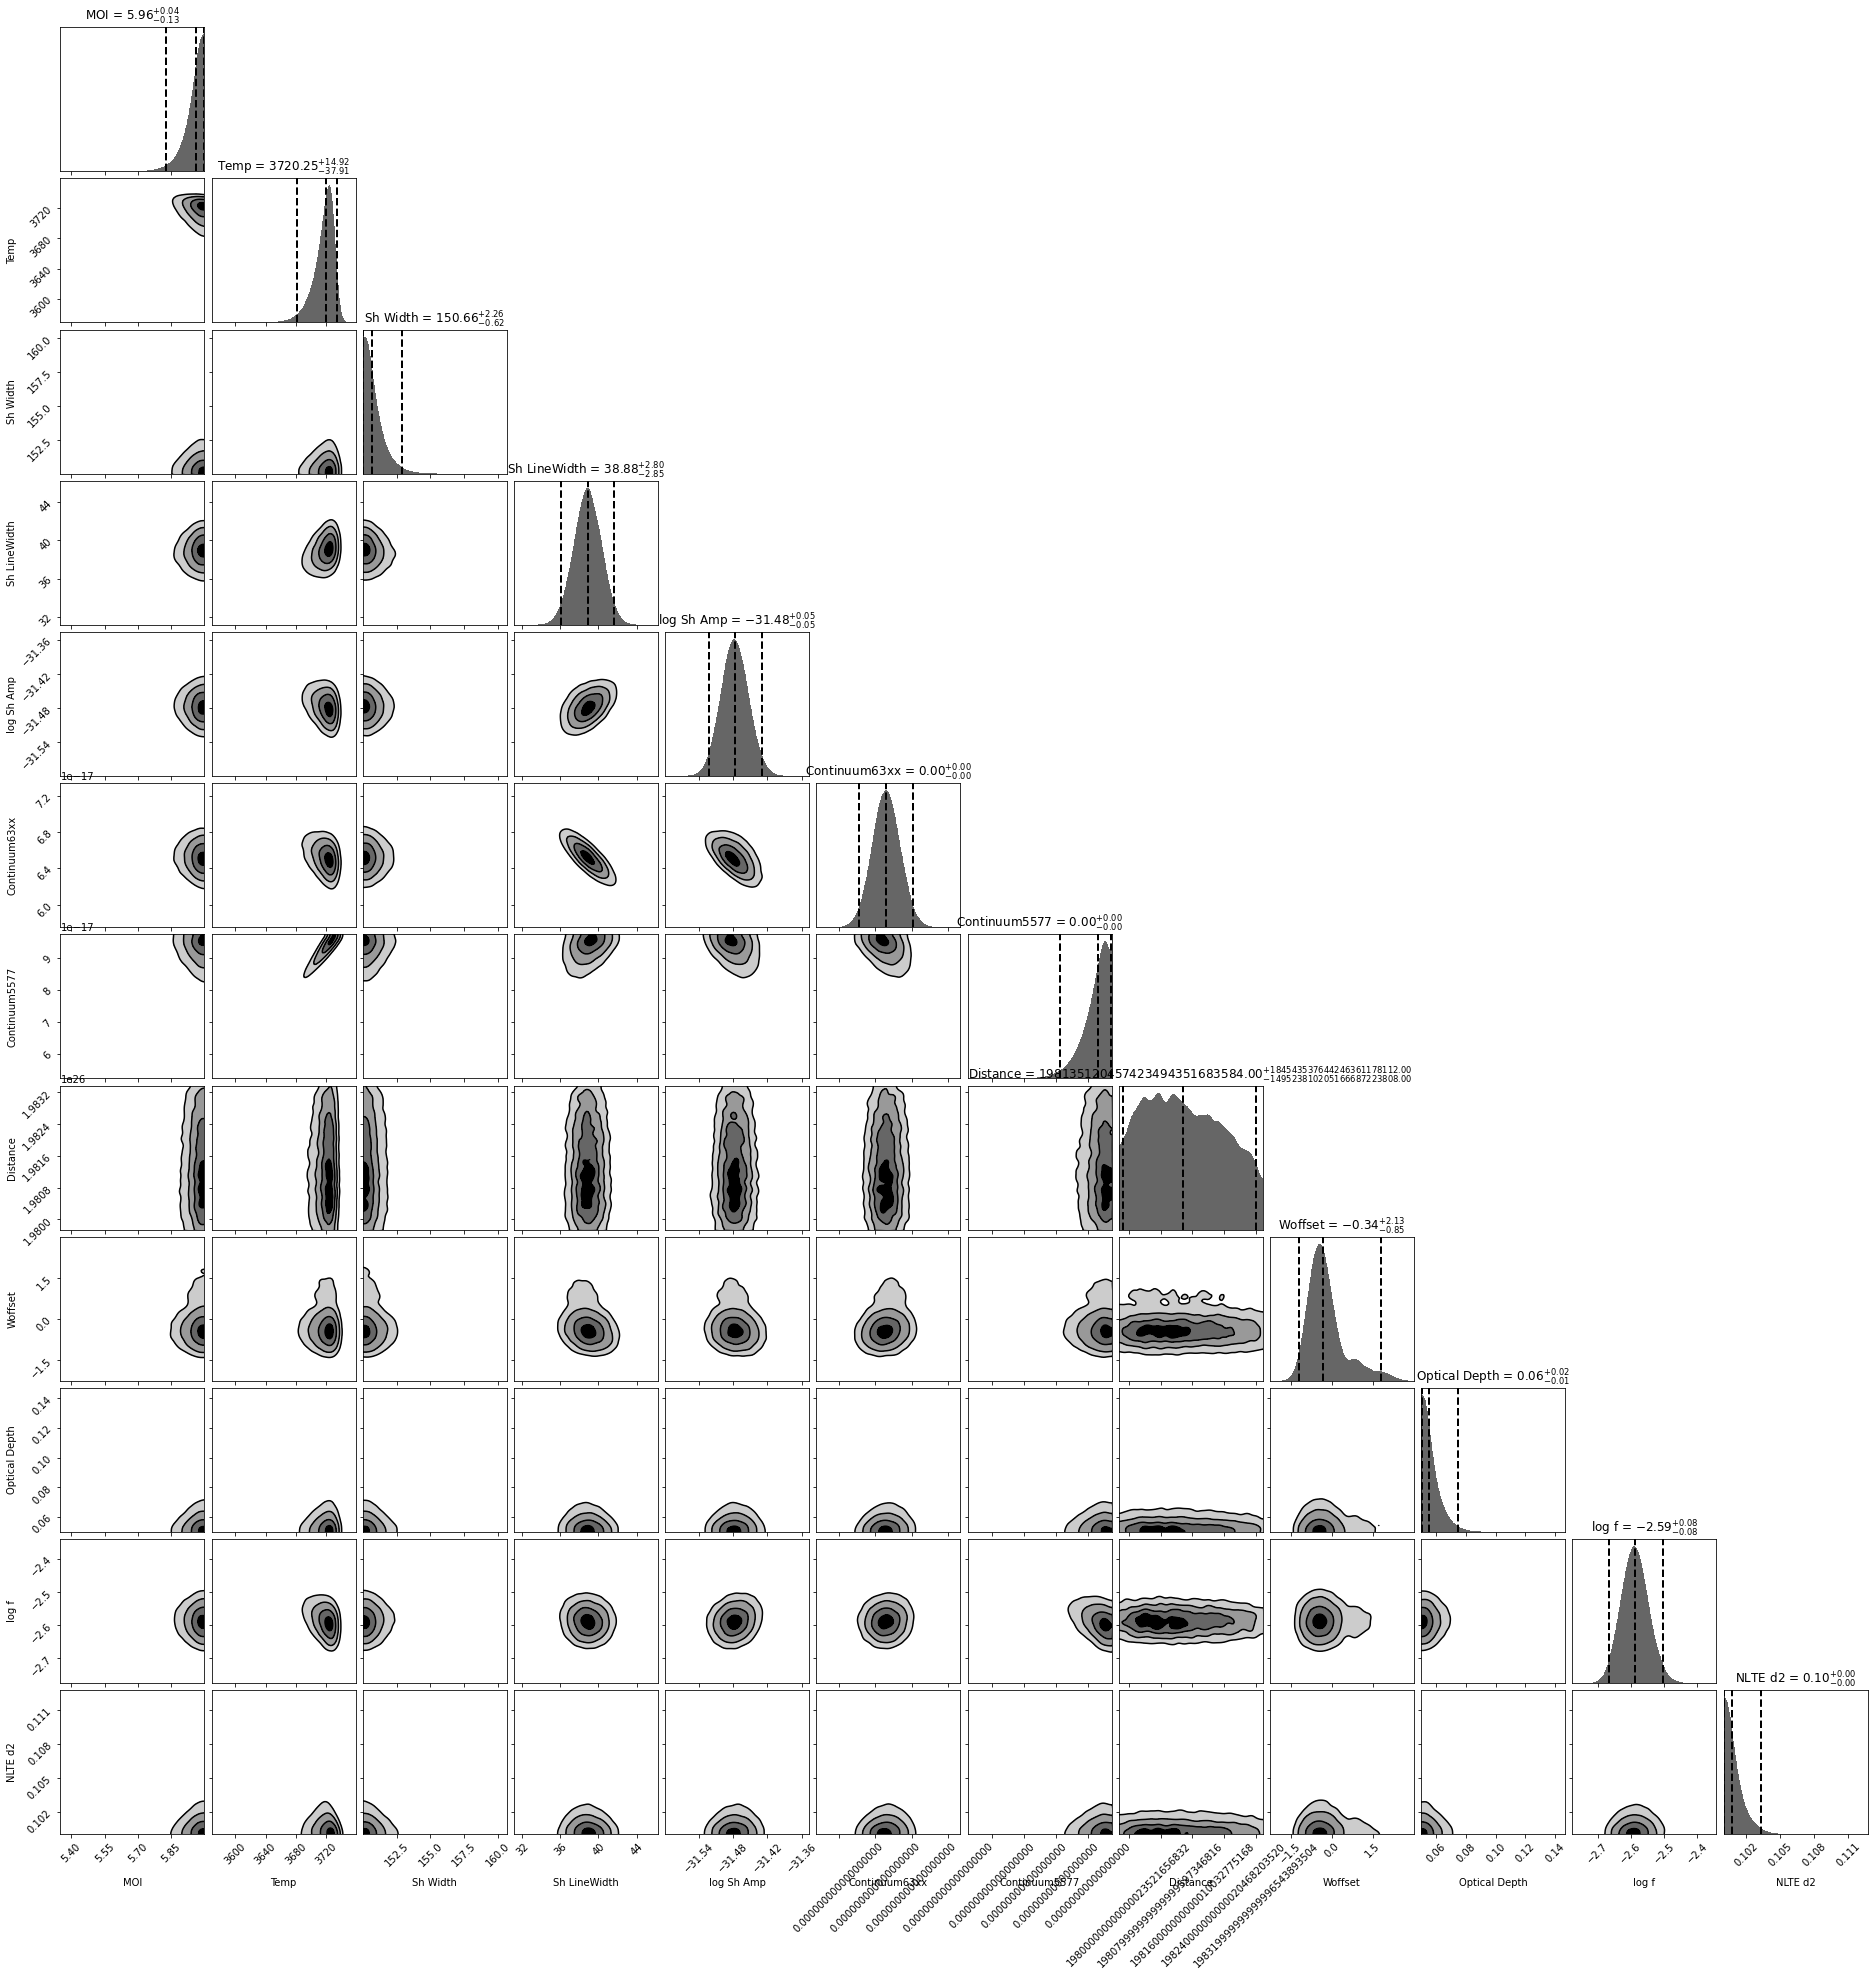

In [76]:
LABELS = ['MOI', 'Temp', 'Sh Width', 'Sh LineWidth', 'log Sh Amp', 'Continuum63xx', 'Continuum5577', 'Distance', 'Woffset', 'Optical Depth', 'log f', 'NLTE d2']
dyplot.cornerplot(sampler2.results, labels=LABELS, show_titles=True);

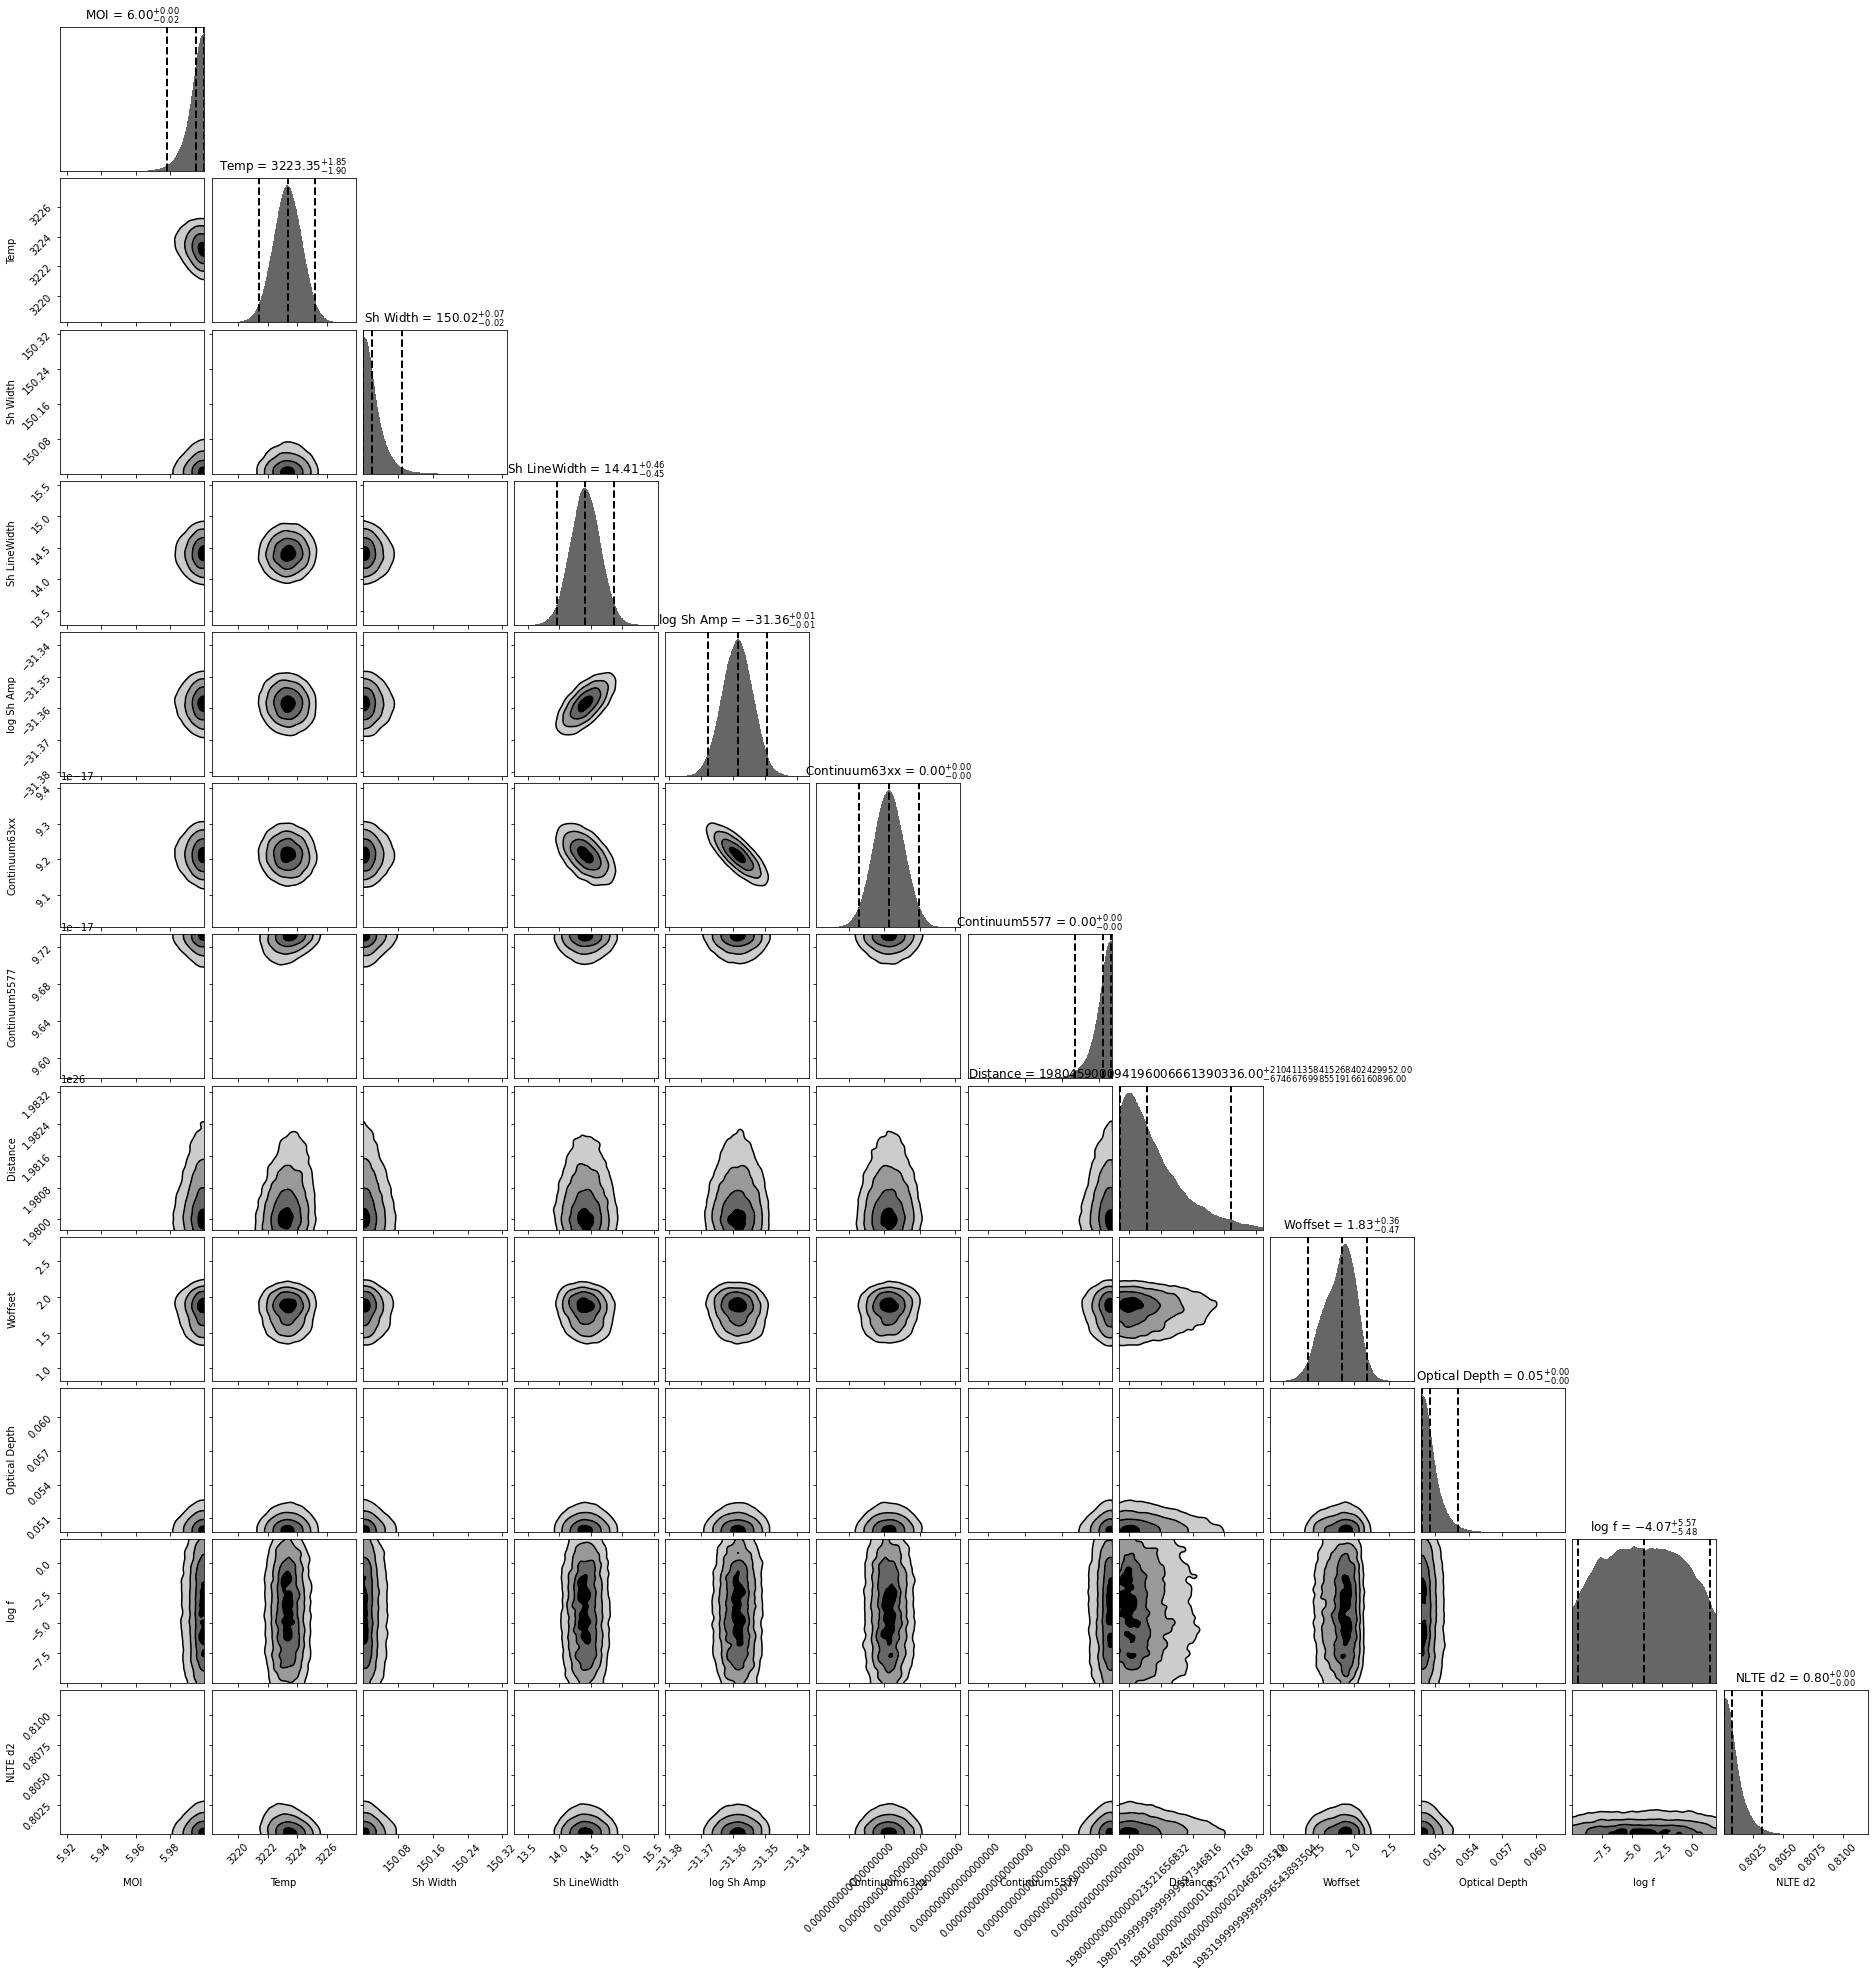

In [89]:
LABELS = ['MOI', 'Temp', 'Sh Width', 'Sh LineWidth', 'log Sh Amp', 'Continuum63xx', 'Continuum5577', 'Distance', 'Woffset', 'Optical Depth', 'log f', 'NLTE d2']
dyplot.cornerplot(sampler4.results, labels=LABELS, show_titles=True);

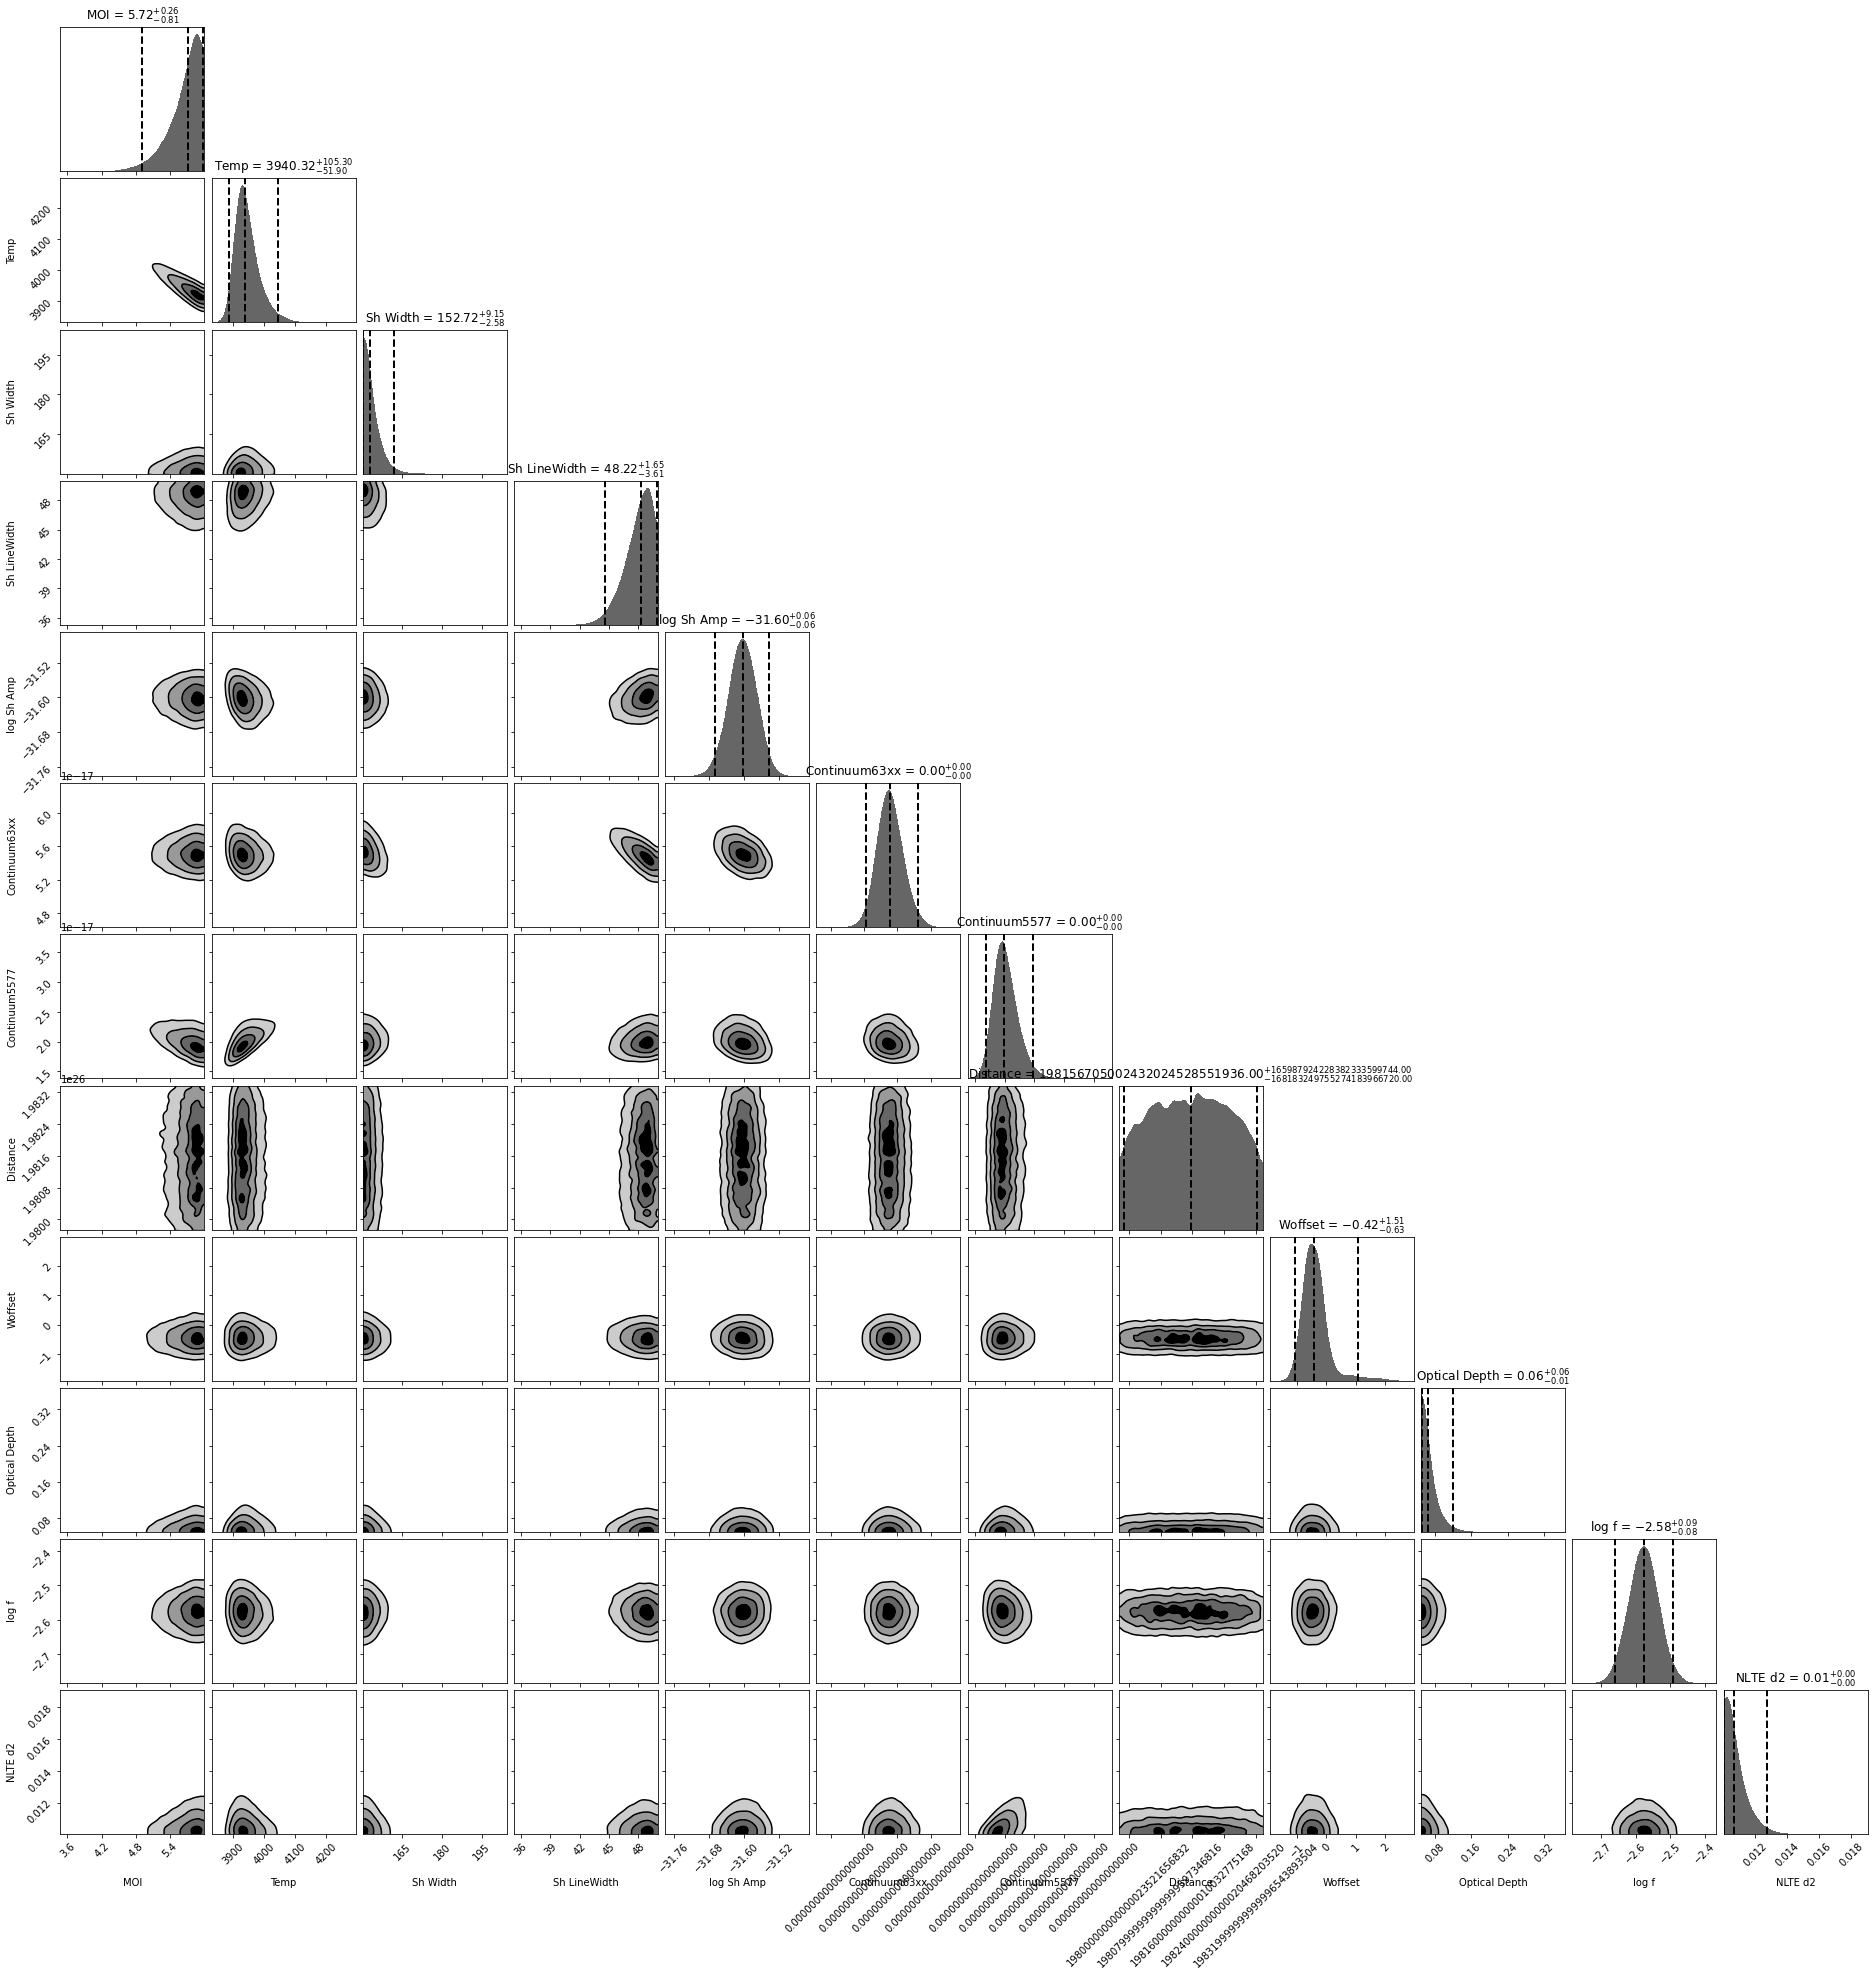

In [110]:
LABELS = ['MOI', 'Temp', 'Sh Width', 'Sh LineWidth', 'log Sh Amp', 'Continuum63xx', 'Continuum5577', 'Distance', 'Woffset', 'Optical Depth', 'log f', 'NLTE d2']
dyplot.cornerplot(sampler7.results, labels=LABELS, show_titles=True);
plt.savefig('2022-08-18-oxygen-7774-constrained-corner.png')

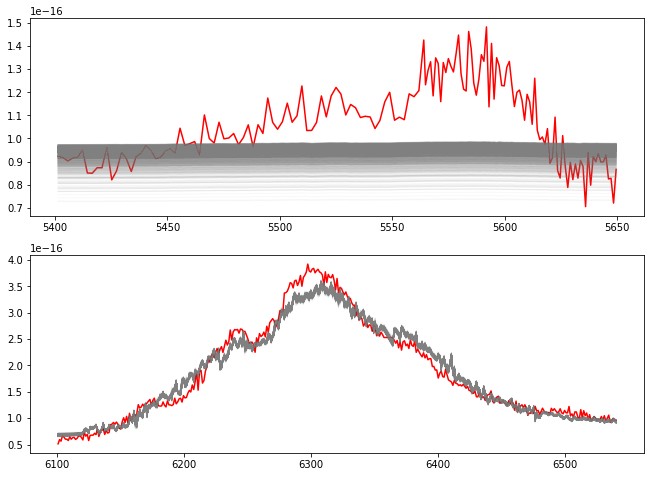

In [78]:
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show2(spec, regions2, trace2, ax1, ax2)

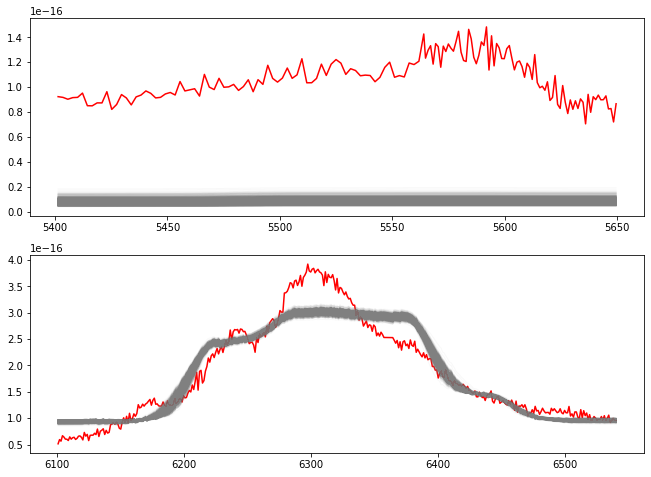

In [84]:
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show2(spec, regions2, trace3, ax1, ax2)

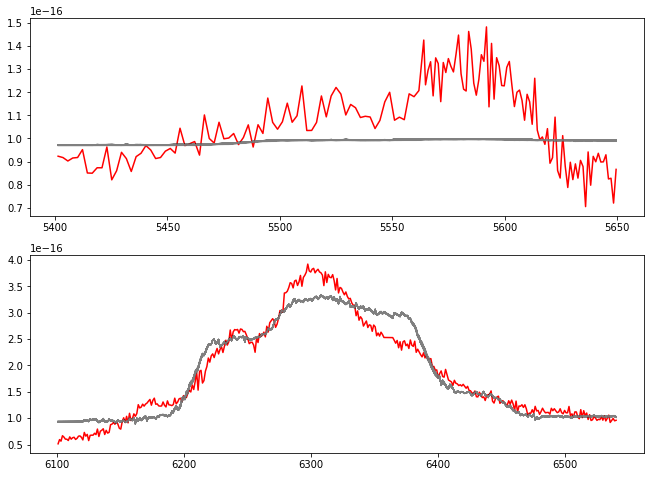

In [87]:
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show2(spec, regions2, trace4, ax1, ax2)

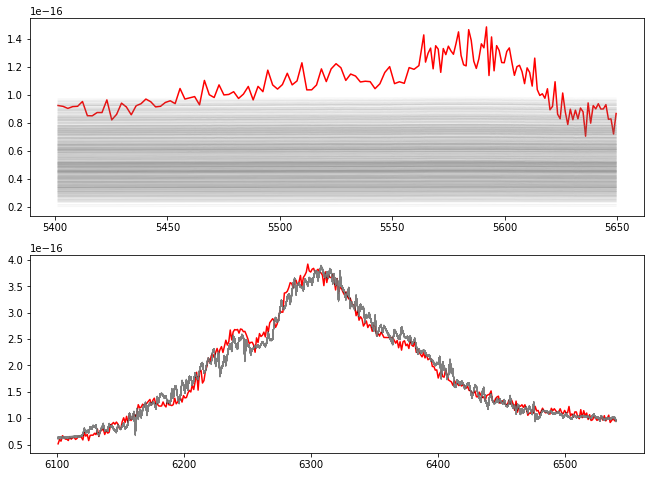

In [94]:
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show2(spec, regions2, trace5, ax1, ax2)

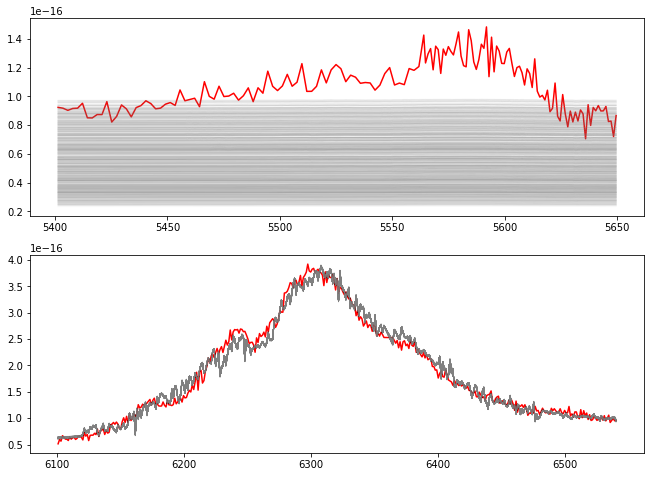

In [102]:
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show2(spec, regions2, trace6, ax1, ax2)

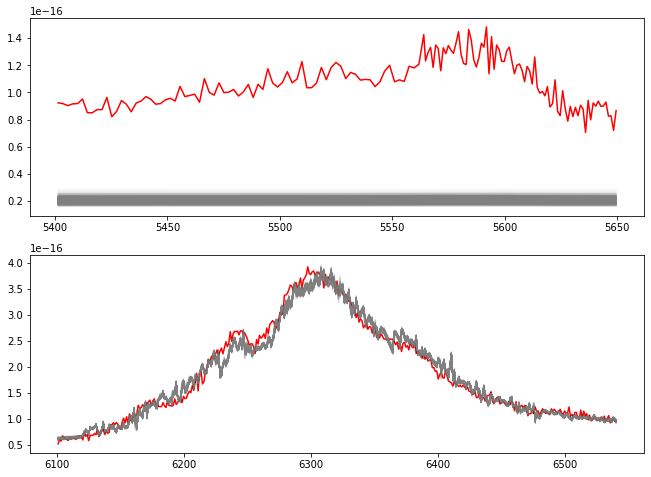

In [108]:
        
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 8))
show2(spec, regions2, trace7, ax1, ax2)

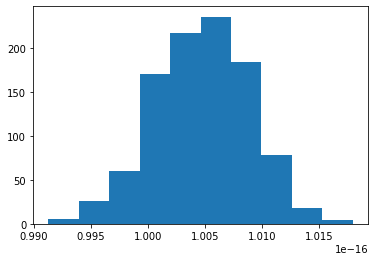

In [133]:
r = np.empty(1000)
for i,idx in enumerate(np.random.randint(trace4.shape[0], size=1000)):
    p = trace4[idx]
    fluxes = oxygen.create_fluxes(p)
    flux_5577 = fluxes[0]
    flux_6300 = fluxes[1]
    flux_6364 = fluxes[2]
    # convert to the different format used by the new generation functions
    ratio_6364 = flux_6364/flux_6300
    ratio_5577 = flux_5577/flux_6300
    #r[i] = np.exp(p[4])*ratio_5577
    r[i] = flux_5577#flux_6300*ratio_5577
plt.hist(r);

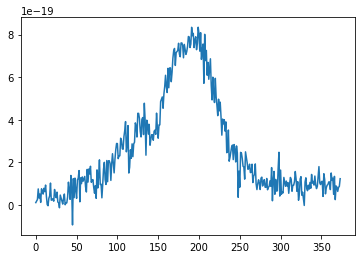

In [135]:
wave_7774, flux_7774 = premangle_7774_flux(spec, wave7774_min=regions['7774_min'], wave7774_max=regions['7774_max'], wave63xx_min=regions['63xx_min'], wave63xx_max=regions['63xx_max'])
plt.plot(flux_7774*1e-16)